# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve CIFAR10 image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 50% (50% points)
    * 60% (60% points)
    * 65% (70% points)
    * 70% (80% points)
    * 75% (90% points)
    * 80% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, theano will do the rest
       * Can be done manually or like [this](https://discuss.pytorch.org/t/simple-l2-regularization/139/2).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root=path_to_cifar_like_in_seminar, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   
```

```

```

```

```

```

```

```


   
There is a template for your solution below that you can opt to use or throw away and write it your way.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [47]:
from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

transform_train = transforms.Compose([
   transforms.RandomRotation(10),
   transforms.RandomResizedCrop(32, scale=(0.85, 1.0), ratio=(0.9, 1.1)),
   transforms.RandomHorizontalFlip(),
   transforms.ToTensor(),
   transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

transform_val = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

transform_test = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

pin_memory = False
val_size = 0.2

trainset = datasets.CIFAR10(root='data', train=True, download=True, transform=transform_train)
valset = datasets.CIFAR10(root='data', train=True, download=False, transform=transform_val)
testset = datasets.CIFAR10(root='data', train=False, download=False, transform=transform_test)
trainset_test = datasets.CIFAR10(root='data', train=True, download=False, transform=transform_test)
valset_test = datasets.CIFAR10(root='data', train=True, download=False, transform=transform_test)

num_train = len(trainset)
indices = np.arange(num_train)
np.random.shuffle(indices)
pivot = int(val_size * num_train)
train_indices, val_indices = indices[pivot:], indices[:pivot]
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

Files already downloaded and verified


__ Training __

In [3]:
from IPython.display import clear_output
import time
from copy import deepcopy

pin_memory = True

def compute_loss(model, X_batch, y_batch):
    X_batch = Variable(X_batch).cuda()
    y_batch = Variable(y_batch).cuda()
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

def train_model(model, trainset, train_sampler=None, valset=None,
                val_sampler=None, training_params=None, timer_limit=14):
    training_params = training_params or {
                                           'num_epochs': 50,
                                           'batch_size': 128,
                                           'initial_lr': 0.001,
                                           'lr_decay_factor': 2,
                                           'lr_decay_stride': 10
                                         }
    num_epochs = training_params['num_epochs']
    batch_size = training_params['batch_size']
    lr = training_params['initial_lr']
    lr_decay_factor = training_params['lr_decay_factor']
    lr_decay_stride = training_params['lr_decay_stride']
    
    if train_sampler is not None:
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler,
                                                  pin_memory=pin_memory, num_workers=1)
    else:
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True,
                                                  pin_memory=pin_memory, num_workers=1)
    if valset is not None:
        if val_sampler is not None:
            valloader = torch.utils.data.DataLoader(valset, batch_size=250, sampler=val_sampler,
                                                    pin_memory=pin_memory, num_workers=1)
        else:
            valloader = torch.utils.data.DataLoader(valset, batch_size=250, shuffle=True,
                                                    pin_memory=pin_memory, num_workers=1)

    train_loss_batches = []
    val_accuracy_batches = [] 
    train_loss_epochs = []
    val_accuracy_epochs = []
    time_epochs = []
    
    best_accuracy = 0.
    best_model_state = None
    timer = 0

    for epoch in range(num_epochs):
        if lr_decay_stride and (epoch + 1) % lr_decay_stride == 0:
            lr /= lr_decay_factor
        opt = torch.optim.Adam(model.parameters(), lr=lr)
        
        start_time = time.time()
        model.train(True)
        for data_batch in trainloader:
            X_batch, y_batch = data_batch
            loss = compute_loss(model, X_batch, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            train_loss_batches.append(loss.cpu().data.numpy()[0])
        train_loss_epochs.append(np.mean(train_loss_batches[-len(trainloader) :]))
        
        if valset is not None:
            model.train(False)
            for data_batch in valloader:
                X_batch, y_batch = data_batch
                logits = model(Variable(X_batch).cuda())
                y_pred = logits.max(1)[1].cpu().data.numpy()
                val_accuracy_batches.append(np.mean(y_batch.numpy() == y_pred))
            val_accuracy_epochs.append(np.mean(val_accuracy_batches[-len(valloader) :]) * 100)
        
        time_epochs.append(time.time() - start_time)
        
        if valset is not None:
            if val_accuracy_epochs[-1] > best_accuracy:
                best_accuracy = val_accuracy_epochs[-1]
                best_model_state = deepcopy(model.state_dict())
                timer = 0
            else:
                timer += 1    
        
        clear_output(True)
        plot_training_log((train_loss_epochs, val_accuracy_epochs))

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time_epochs[-1]))
        print("  training loss (in-iteration): \t{:.6f}".format(
            train_loss_epochs[-1]))
        
        if valset is not None:
            print("  validation accuracy: \t\t\t{:.2f} %".format(
                val_accuracy_epochs[-1]))
            print("  best validation accuracy: \t\t{:.2f} %".format(
                best_accuracy))
        
        if timer > timer_limit:
            break
    
    if valset is not None:
        model.load_state_dict(best_model_state)
    
    return train_loss_epochs, val_accuracy_epochs, time_epochs

def plot_training_log(log, start_epoch=1):
    epochs_num = len(log[0])
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    if len(log[1]):
        plt.title('Train loss and val accuracy')
    else:
        plt.title('Train loss')

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params('y', colors='b')
    ax1.plot(np.arange(start_epoch, epochs_num + 1), log[0][start_epoch-1:], c='b')
    
    if len(log[1]):
        ax2 = ax1.twinx()
        ax2.set_ylabel('Accuracy', color='r')
        ax2.tick_params('y', colors='r')
        ax2.plot(np.arange(start_epoch, epochs_num + 1), log[1][start_epoch-1:], c='r')

    plt.show()

def compute_score(model, dataset, sampler=None, pin_memory=True):
    model.train(False) # disable dropout / use averages for batch_norm
    batch_acc = []

    if sampler is None:
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=250, shuffle=True,
                                                 pin_memory=pin_memory, num_workers=1)
    else:
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=250, sampler=sampler,
                                                 pin_memory=pin_memory, num_workers=1)

    for data_batch in dataloader:
        X_batch, y_batch = data_batch
        logits = model(Variable(X_batch).cuda())
        y_pred = logits.max(1)[1].cpu().data.numpy()
        batch_acc.append(np.mean(y_batch.numpy() == y_pred))
    accuracy = np.mean(batch_acc)

    return accuracy

In [0]:
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1))
model.add_module('conv1_bn', nn.BatchNorm2d(64))
model.add_module('conv1_relu', nn.ReLU())

model.add_module('conv2', nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1))
model.add_module('conv2_bn', nn.BatchNorm2d(64))
model.add_module('pooling2', nn.MaxPool2d(kernel_size=2))
model.add_module('conv2_relu', nn.ReLU())

model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('conv3_bn', nn.BatchNorm2d(128))
model.add_module('conv3_relu', nn.ReLU())

model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1))
model.add_module('conv4_bn', nn.BatchNorm2d(128))
model.add_module('pooling4', nn.MaxPool2d(kernel_size=2))
model.add_module('conv4_relu', nn.ReLU())

model.add_module('conv5', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('conv5_bn', nn.BatchNorm2d(256))
model.add_module('conv5_relu', nn.ReLU())

model.add_module('conv6', nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1))
model.add_module('conv6_bn', nn.BatchNorm2d(256))
model.add_module('pooling6', nn.MaxPool2d(kernel_size=2))
model.add_module('conv6_relu', nn.ReLU())

model.add_module('conv7', nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1))
model.add_module('conv7_bn', nn.BatchNorm2d(512))
model.add_module('pooling7_dropout', nn.Dropout())
model.add_module('pooling7', nn.MaxPool2d(kernel_size=2))
model.add_module('conv7_relu', nn.ReLU())

model.add_module('flatten', Flatten())
model.add_module('conv_to_dense_dropout', nn.Dropout())
model.add_module('dense1', nn.Linear(512 * 2 * 2, 1024))
model.add_module('dense1_bn', nn.BatchNorm1d(1024))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dense1_2_dropout', nn.Dropout())
model.add_module('dense2', nn.Linear(1024, 1024))
model.add_module('dense2_bn', nn.BatchNorm1d(1024))
model.add_module('dense2_relu', nn.ReLU())
model.add_module('dense2_logits', nn.Linear(1024, 10))

model.cuda()
_ = _

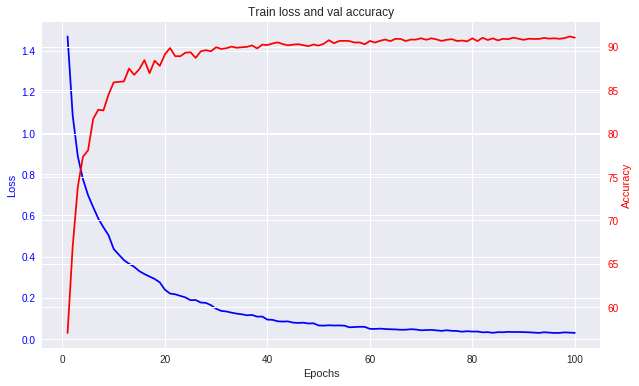

Epoch 100 of 100 took 55.218s
  training loss (in-iteration): 	0.029802
  validation accuracy: 			91.06 %
  best validation accuracy: 		91.20 %
{'test': 0.9080000000000001, 'train': 0.9997250000000001, 'val': 0.9120000000000001}


In [58]:
fname = 'model_27.dat'

training_params = {
    'num_epochs': 100,
    'batch_size': 64,
    'initial_lr': 0.001,
    'lr_decay_factor': 1.5,
    'lr_decay_stride': 10
}

log = train_model(model, trainset, train_sampler, valset, val_sampler, training_params)
test_score = compute_score(model, testset)
train_score = compute_score(model, trainset_test, train_sampler)
val_score = compute_score(model, valset_test, val_sampler)

results = {
    'model_state': model.state_dict(),
    'model_description': str(model),
    'training_params': training_params,
    'training_log': log,
    'scores': {
                'test': test_score,
                'train': train_score,
                'val': val_score
              }
}

torch.save(results, fname)
files.download(fname)

print(results['scores'])

In [59]:
test_score = compute_score(model, testset)
train_score = compute_score(model, trainset_test, train_sampler)
val_score = compute_score(model, valset_test, val_sampler)

print(test_score)
print(train_score)
print(val_score)

0.908
0.9997250000000001
0.9120000000000001


In [0]:
from copy import deepcopy

model_original = deepcopy(model)

In [0]:
def add_weights(model1, model2):
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        param1.data += param2.data

def update_batchnorm(trainloader, model):
    model.train(True)

    for data, target in trainloader:
        data, target = Variable(data), Variable(target)
        data = data.cuda()
        output = model(data)

In [ ]:
from tqdm import trange

N = 1

val_accuracy_batches = []
val_accuracy_epochs = []
n_epochs = 50

trainloader = torch.utils.data.DataLoader(trainset, batch_size=68, sampler=train_sampler,
                                          pin_memory=pin_memory, num_workers=1)
valloader = torch.utils.data.DataLoader(valset, batch_size=250, sampler=val_sampler,
                                        pin_memory=pin_memory, num_workers=1)
model = deepcopy(model_original)
model_avg = deepcopy(model)

opt = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

model.train(False)
for data_batch in valloader:
    X_batch, y_batch = data_batch
    logits = model(Variable(X_batch).cuda())
    y_pred = logits.max(1)[1].cpu().data.numpy()
    val_accuracy_batches.append(np.mean(y_batch.numpy() == y_pred))
val_accuracy_epochs.append(np.mean(val_accuracy_batches[-len(valloader) :]) * 100)

for i in trange(n_epochs):
    model.train(True)
    for data_batch in trainloader:
        X_batch, y_batch = data_batch
        loss = compute_loss(model, X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
    add_weights(model_avg, model)
    N += 1
    
    model.train(False)
    for data_batch in valloader:
        X_batch, y_batch = data_batch
        logits = model(Variable(X_batch).cuda())
        y_pred = logits.max(1)[1].cpu().data.numpy()
        val_accuracy_batches.append(np.mean(y_batch.numpy() == y_pred))
    val_accuracy_epochs.append(np.mean(val_accuracy_batches[-len(valloader) :]) * 100)
    
    clear_output(True)
    plt.plot(val_accuracy_epochs)
    plt.show()

for param in model_avg.parameters():
    param.data /= N

update_batchnorm(trainloader, model_avg)

test_score = compute_score(model_avg, testset)
train_score = compute_score(model_avg, trainset_test, train_sampler)
val_score = compute_score(model_avg, valset_test, val_sampler)

print('Test score:', test_score)
print('Train score:', train_score)
print('Val score:', val_score)

fname = 'model_27_averaged.dat'

results = {
    'model_state': model_avg.state_dict(),
    'model_description': str(model_avg),
    'training_log': val_accuracy_epochs,
    'scores': {
                'test': test_score,
                'train': train_score,
                'val': val_score
              }
}

torch.save(results, fname)
files.download(fname)

In [70]:
test_score = compute_score(model_avg, testset)
train_score = compute_score(model_avg, trainset_test, train_sampler)
val_score = compute_score(model_avg, valset_test, val_sampler)

print('Test score:', test_score)
print('Train score:', train_score)
print('Val score:', val_score)

Test score: 0.9113
Train score: 0.9999750000000001
Val score: 0.9164


# Отчёт

Для начала я взял сеть со следующей архитектурой:  
  
C(3x3, 32)-BN-ReLU   
C(3x3, 64)-BN-P(2x2)-ReLU  
C(3x3, 64)-BN-ReLU  
C(3x3, 64)-BN-P(2x2)-ReLU  
F(512)-BN-ReLU  
F(512)-BN-ReLU  
F(10)  

Во всех архитектурах я старался придерживаться логики постепенного увеличения числа каналов и постепенного уменьшения размера картинок в сверточных слоях. В качестве функции активации я всегда использовал релу, потому что у меня есть представление, что все её модификации работают не сильно лучше, и поэтому эксперименты с ними уже не столь принципиальны.

В качестве оптимизатора я всё время использовал Адам. Размер батча брал 128 (в самом конце 64). Также я достаточно быстро, но не сразу, реализовал остановку обучения по качеству на валидации. Правда в какой-то момент я понял, что долгое время сохранял не лучшую модель, а последнюю, но всё же я это заметил и исправил, поэтому последние лучшие модели действительно лучшие.

Сперва я решил проверить, какой прирост в качестве даёт использование убывающего лёрнинг рейта. Для сравнения был взят констатный лёрнинг рэйт величиной 0.001 и убывающий каждые 10 эпох в 2 раза (стартующий из того же 0.001). Графики обучения для этих двух случаев приведены ниже.

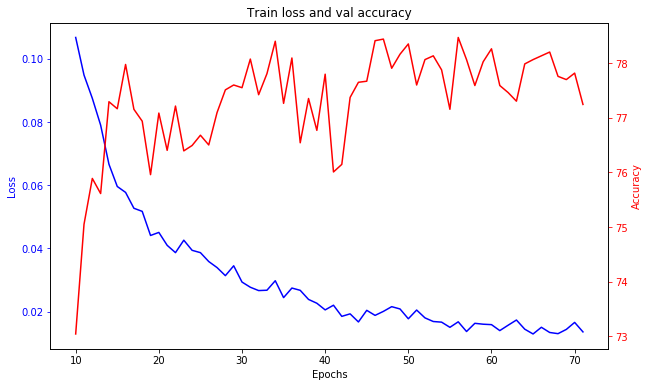

In [4]:
results = torch.load('models/model_1.dat', map_location=lambda storage, loc: storage)
plot_training_log(results['training_log'], 10)

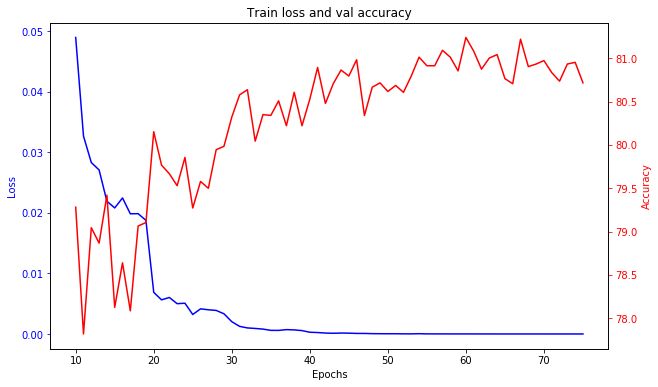

In [5]:
results = torch.load('models/model_2.dat', map_location=lambda storage, loc: storage)
plot_training_log(results['training_log'], 10)

Видно, что убывающий лёрнинг рейт действительно даёт заметно лучшие результаты. И видно, что уже побит скор в 80% точности.

Далее я полистал статью (https://arxiv.org/ftp/arxiv/papers/1512/1512.00242.pdf), где было сказано, что дропаут перед пулингом + дропаут в полносвязных слоях это хорошо, и поэтому вставил перед каждым пулингом и в полносвязных слоях по дропауту. Это сильно ухудшило качество.

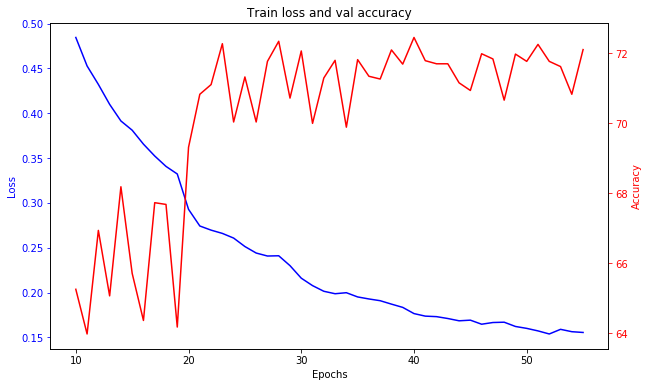

In [6]:
results = torch.load('models/model_3.dat', map_location=lambda storage, loc: storage)
plot_training_log(results['training_log'], 10)

Подумав, я понял, что, наверное, у меня слишком маленькие сверточные слои, чтобы вставлять туда дропауту. При этом самое «толстое» место в сети находится на стыке свёрточного и полносвязного блока. Поэтому теперь я вставил дропаут только на этом стыке. Это значительно улучшило качество.

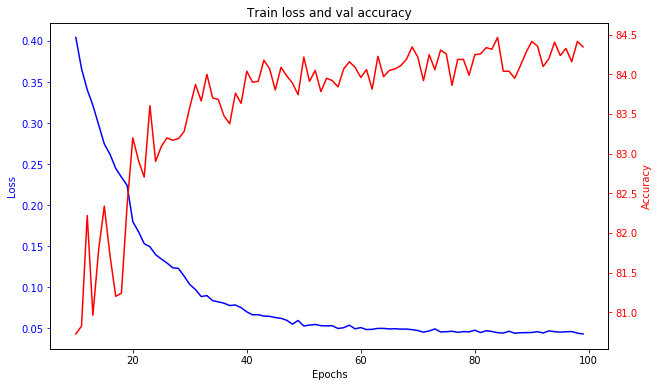

In [7]:
results = torch.load('models/model_5.dat', map_location=lambda storage, loc: storage)
plot_training_log(results['training_log'], 10)

Вдохновленный таким приростом, я пробовал добавить ещё один дропаут в полносвязных слоях или перед одним из пулингов, но это либо ничего не изменяло, либо делало только хуже. 

Далее я просто постепенно наращивал сеть и в итоге пришёл к следующей архитектуре (при этом во всех свёрточных слоях я ещё добавил паддинги): 

C(3x3, 32)-BN-ReLU  
C(3x3, 32)-BN-P(2x2)-ReLU  
C(3x3, 64)-BN-ReLU  
C(3x3, 64)-BN-P(2x2)-ReLU  
C(3x3, 128)-BN-ReLU  
C(3x3, 128)-BN-P(2x2)-ReLU   
DO(0.5)  
F(512)-BN-ReLU  
F(512)-BN-ReLU  
F(10)  

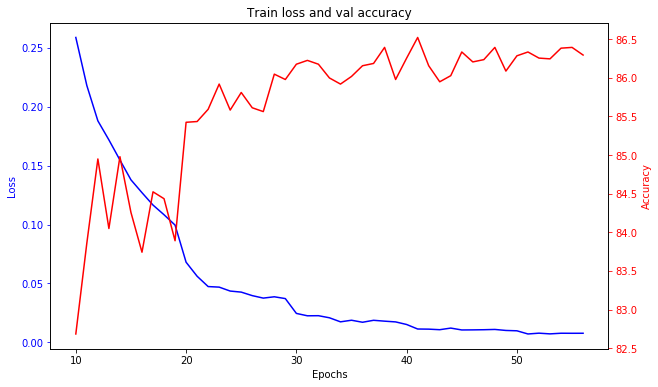

In [8]:
results = torch.load('models/model_10.dat', map_location=lambda storage, loc: storage)
plot_training_log(results['training_log'], 10)

Снова попробовал всунуть куда-нибудь дополнительный дропаут и снова это не дало никаких результатов.  
Тогда, чисто ради интереса, я решил посмотреть, а действительно ли батчнорм улучшает обучение, и поэтому обучил сеть без батчнормов. Это действительно значительно ухудшило качество.

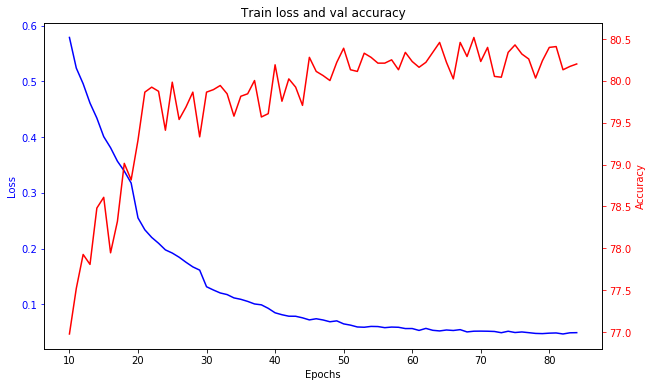

In [9]:
results = torch.load('models/model_13.dat', map_location=lambda storage, loc: storage)
plot_training_log(results['training_log'], 10)

Теперь пришла пора заняться аугментацией. В качестве трансформаций я брал RandomRotation, RandomResizedCrop с небольшими параметрами и RandomHorizontalFlip, а также применял нормализацию (числа были просто взяты из интернета). В итоге это подняло качество за 88%.

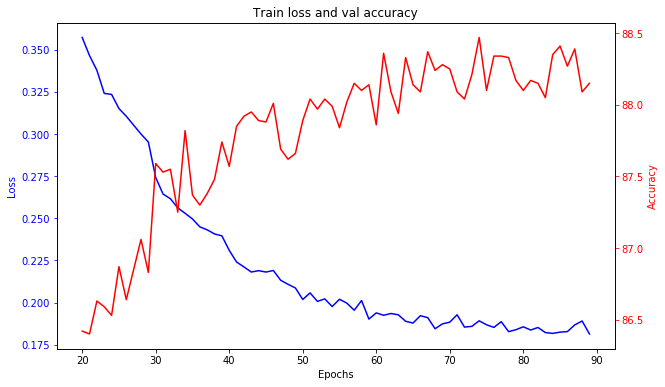

In [10]:
results = torch.load('models/model_16.dat', map_location=lambda storage, loc: storage)
plot_training_log(results['training_log'], 20)

Далее я просто экспериментировал с параметрами аугментации и размером сети. В итоге финальная архитектура имела вид:  
  
C(3x3, 64)-BN-ReLU  
C(3x3, 64)-BN-P(2x2)-ReLU  
C(3x3, 128)-BN-ReLU  
C(3x3, 128)-BN-P(2x2)-ReLU  
C(3x3, 256)-BN-ReLU  
C(3x3, 256)-BN-P(2x2)-ReLU  
C(3x3, 512)-BN-P(2x2)-ReLU  
DO(0.5)  
F(1024)-BN-ReLU   
DO(0.5)  
F(1024)-BN-ReLU  
F(10)  

Для аугментации данных использовались следующие преобразования:   
transforms.RandomRotation(10)    
transforms.RandomResizedCrop(32, scale=(0.85, 1.0), ratio=(0.9, 1.1))  
transforms.RandomHorizontalFlip()  
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  

И, наконец, я немного поэксмериментировал с параметрами оптимизации. Лучшие результаты были получены при размере батча 64 и при убывании лёрнинг рейта каждые 10 эпох на 1.5.

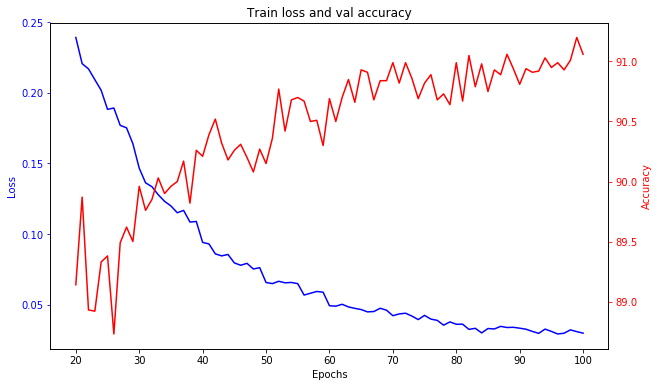

In [11]:
results = torch.load('models/model_27.dat', map_location=lambda storage, loc: storage)
plot_training_log(results['training_log'], 20)

In [12]:
results['scores']

{'test': 0.9080000000000001,
 'train': 0.9997250000000001,
 'val': 0.9120000000000001}

В качестве финального штриха я воспользовался методом улучшения качества обученной модели, замеченным в https://arxiv.org/abs/1803.05407. Этот метод заключается в том, чтобы в качестве весов финальной сети взять среднее по всем точкам траектории обычного SGD с констатным лёрнинг рейтом, запущенного из уже обученной модели.

Таким образом, из уже обученной модели я запустил SGD с лёрнинг рейтром 0.1 на 50 эпох, после чего усреднил веса всех промежуточных моделей. Далее, я один раз прогнал усреднённую модель через трейнсет, чтобы модель смогла восстановить скользящие средние и дисперсии в слоях батчнорма.

In [13]:
results = torch.load('models/model_27_averaged.dat', map_location=lambda storage, loc: storage)
results['scores']

{'test': 0.9113, 'train': 0.9999750000000001, 'val': 0.9164000000000001}

В итоге були получены следующие результаты:

* точность на обучении: __99.99%__
* точность на валидации: __91.64%__
* точность на тесте: __91.13%__